In [3]:
from experiments.regression_0.analysis import Reader
from ga_regression import *
from matplotlib import pyplot as plt
import PIL
import matplotlib as mpl


C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
folder = r"D:\resynth\run_48_49\1k_faces\2025-07-03-07-07-51"  # ok

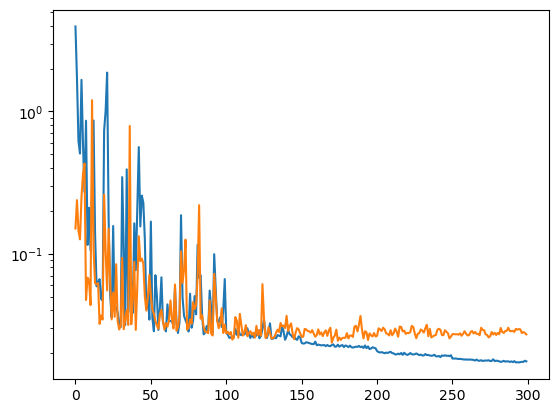

In [5]:
folder = Path(folder)
r = Reader(folder)
meta = r.metadata()
opts = meta['opts']
epoch, ltest = r.scalar('loss/test')
epoch, ltrain = r.scalar('loss/train')
plt.plot(epoch, ltrain, epoch, ltest)
plt.yscale('log')

In [6]:
train_test_scenes = (meta['train_scenes'], meta['test_scenes'])
train_dataset, test_dataset = opts.load_datasets(precalc_ops=True, train_test_scenes=train_test_scenes)

expt = opts.experiment(train_dataset=train_dataset, test_dataset=test_dataset)
expt.model.load_state_dict(torch.load(opts.model_file))

Pre-calculating operators


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:39<00:00, 26.25it/s]


<All keys matched successfully>

In [238]:
train_loader = DataLoader(expt.train_dataset, batch_size=None, shuffle=False)
# test_loader = DataLoader(expt.test_dataset, batch_size=None)
obs_train, preds_train = expt.predict(train_loader, agg_fn=np.stack)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:37<00:00, 26.12it/s]


In [245]:
expt.model.outputs_at = 'vertices'
ch_idx = 4
train_response = (preds_train[:, ch_idx] + obs_train[:, ch_idx]) / 2
best_stim_idxs = np.argsort(train_response)

shape = (nr, nc) = (3, 5)
n_stim = nr * nc

for k, ((i, j), p) in enumerate(iter_subplots(shape=shape, window_size=[2048, 1024])):
    stim_idx = best_stim_idx[-(k + 1)]
    # print(stim_idx)
    data = verts, faces, _frames, mass, *_ = train_dataset[stim_idx]
    labels, preds, weights = expt.load_item(data)
    m = PolyData.from_regular_faces(verts.numpy(), faces.numpy())
    m = m.translate(-np.array(m.center))
    m.point_data['x'] = preds[:, ch_idx].cpu().detach().numpy()
    p.add_mesh(m, scalars=f'x', show_edges=False)

Widget(value='<iframe src="http://localhost:54568/index.html?ui=P_0x12df021e350_80&reconnect=auto" class="pyvi…

- put highlights on the orig upsampled mesh next to the render
- double check highlight colors integrate to best?

In [79]:
expt.model.outputs_at = 'vertices'
ch_idx = 4
train_response = (preds_train[:, ch_idx] + obs_train[:, ch_idx]) / 2
best_stim_idxs = np.argsort(train_response)

shape = (nr, nc) = (3, 5)
n_stim = nr * nc

stim_idxs_to_plot = best_stim_idx[-n_stim:][::-1]
meshes = []

for stim_idx in stim_idxs_to_plot:
    data = verts, faces, _frames, mass, *_ = train_dataset[stim_idx]
    labels, preds, weights = expt.load_item(data)
    m = PolyData.from_regular_faces(verts.numpy(), faces.numpy())
    m = m.translate(-np.array(m.center))
    m.point_data['x'] = preds[:, ch_idx].cpu().detach().numpy()
    meshes.append(m)

min_x = min(m.point_data['x'].min() for m in meshes)
max_x = max(m.point_data['x'].max() for m in meshes)

In [85]:
p = pv.Plotter()
p.add_mesh(meshes[0], scalars='x', clim=(min_x, max_x), scalar_bar_args=dict(title=None, title_font_size=25))
# p.add_scalar_bar for scalar bar kwargs
p.show()

Widget(value='<iframe src="http://localhost:54568/index.html?ui=P_0x12c24152b60_52&reconnect=auto" class="pyvi…

ga_dataset.GaDataset

In [121]:
p.camera.focal_point

(0.0316634476184845, -0.01790936291217804, -0.8730320036411285)

In [125]:
opts.mesh_file_mode

'simplified'

In [126]:
scenes, responses, op_cache_dir, weights, fit_fns = GaDataset.load_data(
    data_file=root,
    k_eig=opts.k_eig,
    channel=opts.channel,
    file_mode=opts.mesh_file_mode,
    norm_verts=opts.norm_verts,
    spike_window=opts.spike_window,
    precalc_ops=True,
    weight_error=opts.weight_error,
)

Pre-calculating operators


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [07:11<00:00,  2.39it/s]


In [128]:
dataset = GaDataset(
    df=scenes,
    responses=responses,
    root_dir=root.parent,
    k_eig=opts.k_eig,
    op_cache_dir=op_cache_dir,
    normalize=opts.norm_verts,
    file_mode=opts.mesh_file_mode,
    weights=weights,
)

In [147]:
i = 0
for x in tqdm(loader):
    i +=1
i

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:06<00:00, 157.30it/s]


1030

In [148]:
expt.model.outputs_at = 'global_mean'
loader = DataLoader(dataset, batch_size=None, shuffle=False)
obs, preds = expt.predict(loader, agg_fn=np.stack)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:24<00:00, 41.90it/s]


In [144]:
expt.model.outputs_at = 'vertices'
ch_idx = 0
avg_response = (obs[:, ch_idx] + preds[:, ch_idx]) / 2
best_stim_idxs = np.argsort(avg_response)
shape = (nr, nc) = (3, 5)
n_stim = nr * nc

for k, ((i, j), p) in enumerate(iter_subplots(shape=shape, window_size=[2048, 1024])):
    stim_idx = best_stim_idx[-(k + 1)]
    data = verts, faces, _frames, mass, *_ = dataset[stim_idx]
    _, vert_weights, _ = expt.load_item(data)
    m = PolyData.from_regular_faces(verts.numpy(), faces.numpy())
    m = m.translate(-np.array(m.center))
    m.point_data['x'] = vert_weights[:, ch_idx].cpu().detach().numpy()
    p.add_mesh(m, scalars=f'x', show_edges=False)

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [234]:
opts.channel[ch_idx]

14

In [185]:
r = scenes.iloc[stim_idx]
render_img = PIL.Image.open(root.parent / r.render)
m_full = pv.read(root.parent / r.remeshed)
m_simp = pv.read(root.parent / r.simplified)

expt.model.outputs_at = 'vertices'
data = verts, faces, _frames, mass, *_ = dataset[stim_idx]
_, vert_weights, _ = expt.load_item(data)
m_simp.point_data['x'] = vert_weights[:, ch_idx].cpu().detach().numpy()

p = pv.Plotter(window_size=(1024, 1024))
p.add_mesh(m_simp, scalars='x', show_scalar_bar=False)
p.camera.position = m_full.field_data['cam_pos']
p.camera.focal_point = m_full.field_data['cam_focal_point']
p.camera.up = m_full.field_data['cam_view_up']
# p.show()
mesh_img = PIL.Image.fromarray(p.screenshot())
render_img = PIL.Image.open(root.parent / r.render)

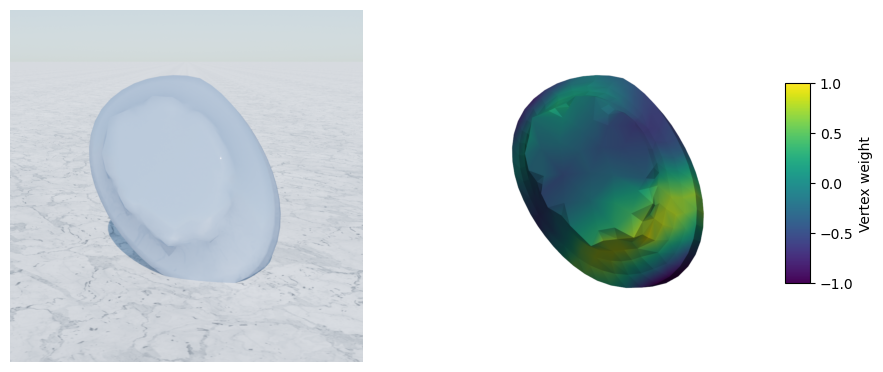

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, img in zip(axs, (render_img, mesh_img)):
    if img:
        ax.imshow(img)
    ax.axis('off')

cax = fig.add_axes([.9, .3, .025, .4])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cb = plt.colorbar(mappable, cax=cax, label='Vertex weight')

In [232]:
p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0)
p.add_mesh(m_full.interpolate(m_simp), scalars='x', show_edges=False)
p.subplot(0, 1)
p.add_mesh(m_simp, scalars='x', show_edges=False)
p.link_views()
p.show()

Widget(value='<iframe src="http://localhost:54568/index.html?ui=P_0x12df6165180_74&reconnect=auto" class="pyvi…